In [1]:
from mmdet.apis import init_detector, inference_detector
import math
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import matplotlib.colors as mcolors

In [2]:
#config = 'mmdet_configs/configs/faster_rcnn/faster_rcnn_r50_fpn_2x_coco.py'
#config = 'mmdet_configs/configs/yolo/yolov3_d53_fp16_mstrain-608_273e_coco.py'
config = 'cracks_tood.py'
#checkpoint = 'faster_rcnn_r50_fpn_2x_coco_bbox_mAP-0.384_20200504_210434-a5d8aa15.pth'
#checkpoint = 'yolov3_d53_fp16_mstrain-608_273e_coco_20210517_213542-4bc34944.pth'
checkpoint = 'tood.pth'
device = 'cuda:0'

In [3]:
model = init_detector(config, checkpoint, device)

load checkpoint from local path: tood.pth


2022-07-21 11:17:50,825 - root - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
2022-07-21 11:17:50,828 - root - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.
2022-07-21 11:17:50,830 - root - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
2022-07-21 11:17:50,833 - root - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
2022-07-21 11:17:50,836 - root - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
2022-07-21 11:17:50,839 - root - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
2022-07-21 11:17:50,842 - root - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
2022-07-21 11:17:50,845 - root - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
2022-07-21 11:17:50,847 - root - INFO - ModulatedDeformConvPack backbone.layer3.4.conv2 

In [4]:
label_names=['Arrachement_pelade', 'Faiencage', 'Nid_de_poule',
                 'Transversale', 'Longitudinale', 'Reparation']

In [5]:
colors_list = [[1,0,0], [0,1,0], [0,0,1], [1,0,1], [0,1,1], [1,1,0]]
cmaps = []
for ic in range(len(label_names)):
    colors = [(colors_list[ic][0], colors_list[ic][1], colors_list[ic][2], c) for c in np.linspace(0,1,100)]
    cmaps.append( mcolors.LinearSegmentedColormap.from_list(f'mycmap{ic}', colors, N=5) )

In [6]:
def parse_yolo_annotation(annotation_txtpath):
    """ Parse a yolo annotation file. """
    annotations = []
    with open(annotation_txtpath, "rt") as f_in:
        for line in f_in.readlines():
            line = line.strip()

            cls, x_center, y_center, width, height = line.split()

            annotations.append(
                {
                    "class_index": int(cls),
                    "x_center": float(x_center),
                    "y_center": float(y_center),
                    "width": float(width),
                    "height": float(height),
                }
            )
    return annotations


def yolo_annotations_to_box(yolo_annotations, image, label_names):
    """ Convert a yolo annotation list to (x1, y1, x2, y2) coordinates."""
    image_width = image.shape[1]
    image_height = image.shape[0]
    box_annotations = [[] for _ in range(len(label_names))]

    for annotation in yolo_annotations:
        x1 = int(round((annotation["x_center"]-annotation['width']/2) * image_width))
        if x1 < 0:
            x1 = 0
        y1 = int(round((annotation["y_center"]-annotation['height']/2) * image_height))
        if y1 < 0:
            y1 = 0
        x2 = int(round((annotation["x_center"]+annotation['width']/2) * image_width))
        y2 = int(round((annotation["y_center"]+annotation['height']/2) * image_height))
        box_annotations[annotation['class_index']].append([x1,y1,x2,y2])

    for c in range(len(label_names)):
        if len(box_annotations[c]) > 0:
            box_annotations[c] = np.stack(box_annotations[c])

    return box_annotations

In [7]:
def iou(boxes, box):
    box = np.asarray(box)
    tl = np.maximum(boxes[:,:2], box[:2])
    br = np.minimum(boxes[:,2:], box[2:])
    intersection = np.prod(br - tl, axis=1) * np.all(tl < br, axis=1).astype(float)
    area1 = np.prod(boxes[:,2:] - boxes[:,:2], axis=1)
    area2 = np.prod(box[2:] - box[:2])
    return intersection / (area1 + area2 - intersection)

In [8]:
def intersect_over_pred(boxes, box):
    '''
    intersection of box with each box in boxes, divided by area of box
    '''
    box = np.asarray(box)
    tl = np.maximum(boxes[:,:2], box[:2])
    br = np.minimum(boxes[:,2:], box[2:])
    intersection = np.prod(br - tl, axis=1) * np.all(tl < br, axis=1).astype(float)
    area = np.prod(box[2:] - box[:2])
    return intersection / area

In [9]:
def nms(boxes, scores, thresh):
    '''
    boxes is a numpy array : num_boxes, 4
    scores ia  nump array : num_boxes,
    '''
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = boxes[:, 2]
    y2 = boxes[:, 3]

    areas = (x2 - x1 + 1) * (y2 - y1 + 1)
    order = scores.argsort()[::-1] # get boxes with more ious first

    keep = []
    while order.size > 0:
        i = order[0] # pick maxmum iou box
        keep.append(i)
        xx1 = np.maximum(x1[i], x1[order[1:]])
        yy1 = np.maximum(y1[i], y1[order[1:]])
        xx2 = np.minimum(x2[i], x2[order[1:]])
        yy2 = np.minimum(y2[i], y2[order[1:]])

        w = np.maximum(0.0, xx2 - xx1 + 1) # maximum width
        h = np.maximum(0.0, yy2 - yy1 + 1) # maxiumum height
        inter = w * h
        ovr = inter / (areas[i] + areas[order[1:]] - inter)

        inds = np.where(ovr <= thresh)[0]
        order = order[inds + 1]

    return keep

In [10]:
def get_boxes_overlap(target_boxes):
    '''
    Get target boxes that overlap each other
    '''
    boxes_overlap = []
    other_boxes = []
    for boxes in target_boxes:
        if len(boxes) > 1:
            iou_matrix = []
            for box in boxes:
                iou_matrix.append(iou(boxes, box))
            iou_matrix = np.array(iou_matrix)
            overlap_ind = np.unique(np.where((iou_matrix>0) & (iou_matrix<1))[0])
            if len(overlap_ind) > 0:
                boxes_overlap.append( np.stack(boxes[overlap_ind]) )
            else:
                boxes_overlap.append([])
                
            other_ind = np.where(iou_matrix.sum(axis=1)==1)[0]
            if len(other_ind) > 0:
                other_boxes.append( np.stack(boxes[other_ind]) )
            else:
                other_boxes.append([])
        elif len(boxes)==1:
            boxes_overlap.append([])
            other_boxes.append(boxes)
        else:
            boxes_overlap.append([])
            other_boxes.append([])
            
    return boxes_overlap, other_boxes

In [11]:
def distance(boxes, box):
    '''
    Get distance between selected corners in box and boxes
    '''
    d = np.sum(box**2 + boxes**2 - 2*box*boxes, axis=1)
    d = np.sqrt(d)
    return d
    
def get_boxes_diagonal(target_boxes):
    '''
    Get boxes that cover diagonal defect:
    measure distance between top left and bottom right corners,
    and top right and bottom left corners
    '''
    boxes_diagonal = []
    other_boxes = []
    for boxes in target_boxes:
        if len(boxes) > 1:
            diag_ind = []
            other_ind = []
            for i, box in enumerate(boxes):
                dist_matrix = []
                
                box_bottom_right = box[[2,3]]
                boxes_top_left = boxes[:,[0,1]]
                dist_matrix.append(distance(boxes_top_left, box_bottom_right))
                
                box_top_right = box[[2,1]]
                boxes_bottom_left = boxes[:,[0,3]]
                dist_matrix.append(distance(boxes_bottom_left, box_top_right))

                boxes_bottom_right = boxes[:,[2,3]]
                box_top_left = box[[0,1]]
                dist_matrix.append(distance(boxes_bottom_right, box_top_left))
                
                boxes_top_right = boxes[:,[2,1]]
                box_bottom_left = box[[0,3]]
                dist_matrix.append(distance(boxes_top_right, box_bottom_left))
                
                dist_matrix = np.array(dist_matrix)
                if np.where(dist_matrix<50, True, False).sum() > 0:
                    diag_ind.append(i)
                else:
                    other_ind.append(i)
                    
            if len(diag_ind) > 0:
                boxes_diagonal.append( np.stack(boxes[diag_ind]) )
            else:
                boxes_diagonal.append([])
                
            if len(other_ind) > 0:
                other_boxes.append( np.stack(boxes[other_ind]) )
            else:
                other_boxes.append([])
                
        elif len(boxes)==1:
            boxes_diagonal.append([])
            other_boxes.append(boxes)
        else:
            boxes_diagonal.append([])
            other_boxes.append([])
            
    return boxes_diagonal, other_boxes

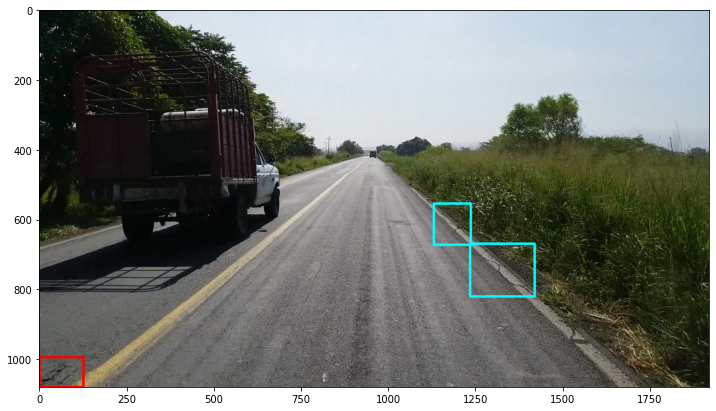

In [81]:
image_path = 'images/7._Poza_Rica_-_Veracruz_no_name_20211027_114318_709-009503.jpg'
image_dir = 'images/'
annot_dir = 'images/'

image = cv2.imread(image_path)
#scale = 600 / min(image.shape[:2])
#image = cv2.resize(image,
#                   None,
#                   fx=800 / image.shape[1],
#                   fy=640 / image.shape[0],
#                   interpolation=cv2.INTER_AREA)

yolo_ann = parse_yolo_annotation(image_path.replace('.jpg', '.txt').replace(image_dir, annot_dir))
target_boxes = yolo_annotations_to_box(yolo_ann, image, label_names)

res = image.copy()
for ic in range(len(label_names)):
    for i in range(len(target_boxes[ic])):
            cv2.rectangle(res, target_boxes[ic][i,:2], target_boxes[ic][i, 2:],
                          (np.flip(np.array(colors_list[ic])*255)).tolist(), 5)
            
plt.figure(figsize=(12, 12))
plt.imshow(res[:, :, ::-1])
plt.show()

#boxes_overlap, other_boxes = get_boxes_overlap(target_boxes)
boxes_diagonal, other_boxes = get_boxes_diagonal(target_boxes)

# Add overlapping boxes

In [76]:
def get_center(box):
    x1, y1, x2, y2 = box
    x_center = int((x1 + x2) / 2)
    y_center = int((y1 + y2) / 2)
    
    return x_center, y_center

def make_overlap_box(box1, box2):
    x_center1, y_center1 = get_center(box1)
    x_center2, y_center2 = get_center(box2)
    
    if x_center1 < x_center2:
        x1 = x_center1
        x2 = x_center2
    else:
        x1 = x_center2
        x2 = x_center1

    if y_center1 < y_center2:
        y1 = y_center1
        y2 = y_center2
    else:
        y1 = y_center2
        y2 = y_center1

    return [x1, y1, x2, y2]

def make_overlap_boxes(target_boxes):
    '''
    Get boxes that cover diagonal defect:
    measure distance between top left and bottom right corners,
    and top right and bottom left corners
    '''
    new_target_boxes = []
    for boxes in target_boxes:
        if len(boxes) > 1:
            new_boxes = boxes.tolist()
            for i, box in enumerate(boxes):
                dist_matrix = []
                
                box_bottom_right = box[[2,3]]
                boxes_top_left = boxes[:,[0,1]]
                dist_matrix.append(distance(boxes_top_left, box_bottom_right))
                
                box_top_right = box[[2,1]]
                boxes_bottom_left = boxes[:,[0,3]]
                dist_matrix.append(distance(boxes_bottom_left, box_top_right))

                boxes_bottom_right = boxes[:,[2,3]]
                box_top_left = box[[0,1]]
                dist_matrix.append(distance(boxes_bottom_right, box_top_left))
                
                boxes_top_right = boxes[:,[2,1]]
                box_bottom_left = box[[0,3]]
                dist_matrix.append(distance(boxes_top_right, box_bottom_left))
                
                dist_matrix = np.array(dist_matrix)
                diag_ind = np.where(dist_matrix<50)[1]
                
                for ind in diag_ind:
                    if ind != i:
                        overlap_box = make_overlap_box(box, boxes[ind])
                        new_boxes.append(overlap_box)
                        
            new_boxes = np.unique(np.stack(new_boxes), axis=0)
            
        else:
            new_boxes = boxes
        new_target_boxes.append(new_boxes)
            
    return new_target_boxes

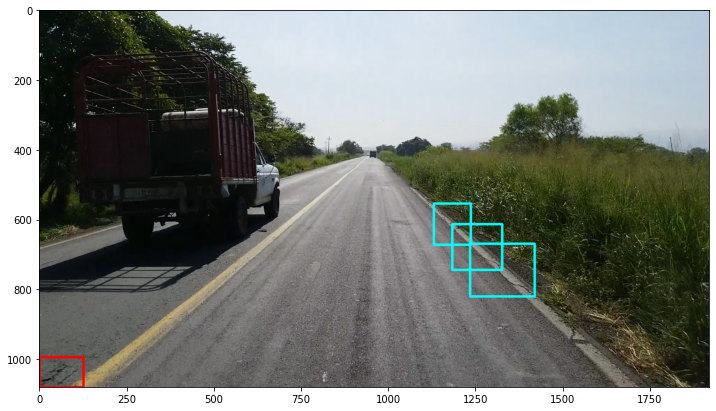

In [82]:
target_boxes_overlap = make_overlap_boxes(target_boxes)

res = image.copy()
for ic in range(len(label_names)):
    for i in range(len(target_boxes_overlap[ic])):
            cv2.rectangle(res, target_boxes_overlap[ic][i,:2], target_boxes_overlap[ic][i, 2:],
                          (np.flip(np.array(colors_list[ic])*255)).tolist(), 5)
            
plt.figure(figsize=(12, 12))
plt.imshow(res[:, :, ::-1])
plt.show()

# Infer small boxes

## Method 1

/home/theo/workdir/mmdet/mmdetection/mmdet/datasets/utils.py:70: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)


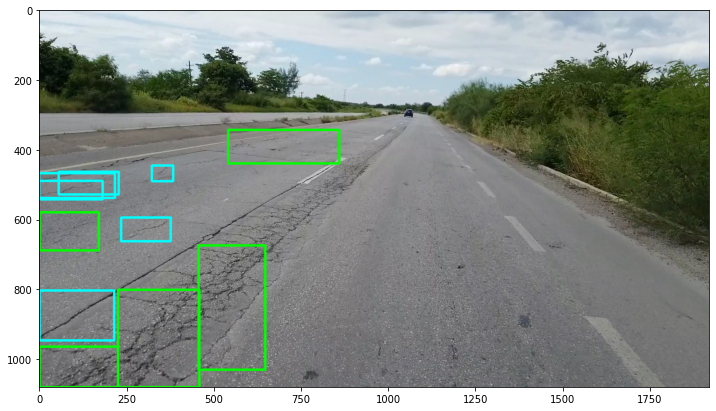

In [18]:
score_threshold = 0.05
iou_threshold = 0.9

out = inference_detector(model, image)
res = image.copy()
pred_boxes = [[] for _ in range(len(label_names))]
pred_scores = [[] for _ in range(len(label_names))]
for i, pred in enumerate(out):
    for *box, score in pred:
        if score < score_threshold:
            continue
        box = tuple(np.round(box).astype(int).tolist())
        pred_boxes[i].append(box)
        pred_scores[i].append(score)
    if len(pred_boxes[i]) > 0:
        pred_boxes[i] = np.stack(pred_boxes[i])
        pred_scores[i] = np.stack(pred_scores[i])
        keep_ind = nms(pred_boxes[i], pred_scores[i], iou_threshold)
        pred_boxes[i] = pred_boxes[i][keep_ind]
        
        for box in pred_boxes[i]:
#            if len(boxes_overlap[i]) > 0:
#                overlap = intersect_over_pred(boxes_overlap[i], box)
#                if (overlap==1).sum() > 0:
#                    cv2.rectangle(res, box[:2], box[2:], (np.flip(np.array(colors_list[i])*255)).tolist(), 5)
            if len(boxes_diagonal[i]) > 0:
                overlap = intersect_over_pred(boxes_diagonal[i], box)
                if (overlap>0.9).sum() > 0:
                    cv2.rectangle(res, box[:2], box[2:], (np.flip(np.array(colors_list[i])*255)).tolist(), 5)

                    
    # boxes without overlap
    for box in other_boxes[i]:
        cv2.rectangle(res, box[:2], box[2:], (np.flip(np.array(colors_list[i])*255)).tolist(), 5)

plt.figure(figsize=(12, 12))
plt.imshow(res[:, :, ::-1])
plt.show()

## Method 2

In [19]:
model = init_detector('cracks_tood_2.py', checkpoint, device)

2022-07-18 10:01:18,637 - root - INFO - ModulatedDeformConvPack backbone.layer2.0.conv2 is upgraded to version 2.
2022-07-18 10:01:18,639 - root - INFO - ModulatedDeformConvPack backbone.layer2.1.conv2 is upgraded to version 2.


load checkpoint from local path: tood.pth


2022-07-18 10:01:18,642 - root - INFO - ModulatedDeformConvPack backbone.layer2.2.conv2 is upgraded to version 2.
2022-07-18 10:01:18,644 - root - INFO - ModulatedDeformConvPack backbone.layer2.3.conv2 is upgraded to version 2.
2022-07-18 10:01:18,646 - root - INFO - ModulatedDeformConvPack backbone.layer3.0.conv2 is upgraded to version 2.
2022-07-18 10:01:18,649 - root - INFO - ModulatedDeformConvPack backbone.layer3.1.conv2 is upgraded to version 2.
2022-07-18 10:01:18,652 - root - INFO - ModulatedDeformConvPack backbone.layer3.2.conv2 is upgraded to version 2.
2022-07-18 10:01:18,654 - root - INFO - ModulatedDeformConvPack backbone.layer3.3.conv2 is upgraded to version 2.
2022-07-18 10:01:18,656 - root - INFO - ModulatedDeformConvPack backbone.layer3.4.conv2 is upgraded to version 2.
2022-07-18 10:01:18,658 - root - INFO - ModulatedDeformConvPack backbone.layer3.5.conv2 is upgraded to version 2.
2022-07-18 10:01:18,660 - root - INFO - ModulatedDeformConvPack backbone.layer3.6.conv2 

In [20]:
def crop_inference(model, image, ic, score_threshold, shift):
    pred_boxes = []
    pred_scores = []
    pred = inference_detector(model, image)[ic]
    for *box, score in pred:
        if score < score_threshold:
            continue
        box = np.round(box).astype(int).tolist()
        box[0] += shift[0]
        box[1] += shift[1]
        box[2] += shift[0]
        box[3] += shift[1]
        pred_boxes.append(box)
        pred_scores.append(score)
    return pred_boxes, pred_scores

In [23]:
score_threshold = 0.05

pred_boxes = [[] for _ in range(len(label_names))]
pred_scores = [[] for _ in range(len(label_names))]
#boxes_overlap_leftover = [[] for _ in range(len(label_names))]
boxes_diagonal_leftover = [[] for _ in range(len(label_names))]

#for ic, boxes in enumerate(boxes_overlap):
for ic, boxes in enumerate(boxes_diagonal):
    for box in boxes:
        x1, y1, x2, y2 = box
        crop = image[y1:y2, x1:x2]
        pred = crop_inference(model, crop, ic, score_threshold, (x1, y1))
        pred_boxes[ic] += pred[0]
        pred_scores[ic] += pred[1]
        if len(pred[0]) == 0:
#            boxes_overlap_leftover[ic].append(box)
            boxes_diagonal_leftover[ic].append(box)
        
    if len(pred_boxes[ic]) > 0:       
        pred_boxes[ic] = np.stack(pred_boxes[ic])


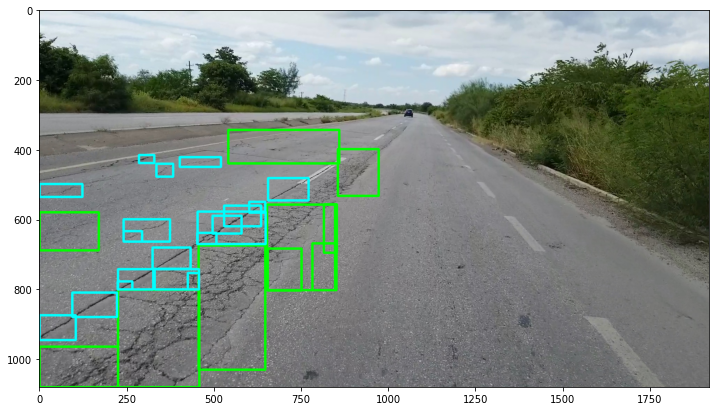

In [24]:
iou_threshold = 0.25

res = image.copy()

for i, (boxes, scores) in enumerate(zip(pred_boxes, pred_scores)):
    # boxes with overlap
    if len(boxes) > 0:
        boxes = np.stack(boxes)
        scores = np.stack(scores)
        keep_ind = nms(boxes, scores, iou_threshold)
        pred_boxes[i] = pred_boxes[i][keep_ind]
        
        for box in pred_boxes[i]:
            cv2.rectangle(res, box[:2], box[2:], (np.flip(np.array(colors_list[i])*255)).tolist(), 5)
            
    # boxes with overlap but no prediction
#    for box in boxes_overlap_leftover[i]:
    for box in boxes_diagonal_leftover[i]:
        cv2.rectangle(res, box[:2], box[2:], (np.flip(np.array(colors_list[i])*255)).tolist(), 5)    
                    
    # boxes without overlap
    for box in other_boxes[i]:
        cv2.rectangle(res, box[:2], box[2:], (np.flip(np.array(colors_list[i])*255)).tolist(), 5)

plt.figure(figsize=(12, 12))
plt.imshow(res[:, :, ::-1])
plt.show()

0 Arrachement_pelade (0, 59, 154, 151) 0.27540618
0 Arrachement_pelade (1, 15, 85, 75) 0.13950582
0 Arrachement_pelade (1, 50, 75, 151) 0.13403952
0 Arrachement_pelade (0, 10, 61, 62) 0.12375029
0 Arrachement_pelade (0, 8, 95, 145) 0.08587635
0 Arrachement_pelade (0, 3, 40, 52) 0.0785525
0 Arrachement_pelade (2, 60, 60, 96) 0.06769382
0 Arrachement_pelade (0, 44, 83, 90) 0.06364884
0 Arrachement_pelade (78, 70, 149, 152) 0.05973987
0 Arrachement_pelade (3, 52, 73, 114) 0.052183814
1 Faiencage (0, 113, 57, 151) 0.06492196


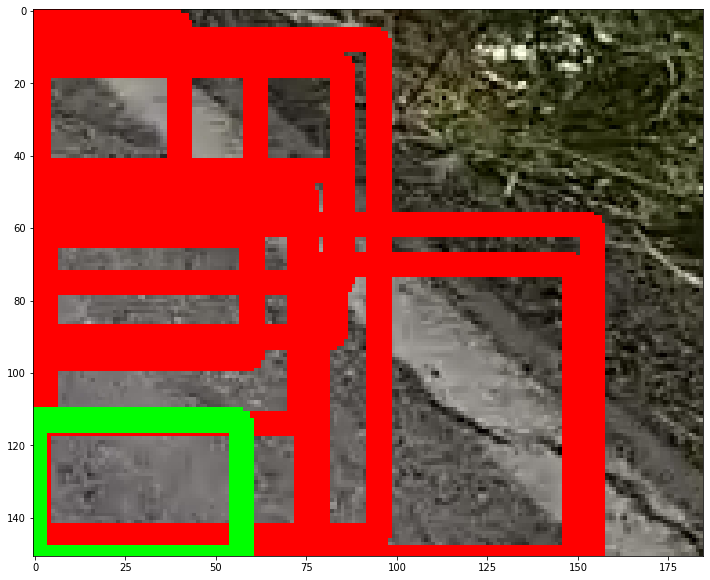

In [36]:
x1, y1, x2, y2 = target_boxes[4][0]
crop = image[y1:y2, x1:x2]
#crop = cv2.resize(crop,
#                   None,
#                   fx=400 / crop.shape[1],
#                   fy=320 / crop.shape[0],
#                   interpolation=cv2.INTER_AREA)

out = inference_detector(model, crop)
res = crop.copy()
for i, pred in enumerate(out):
    for *box, score in pred:
        if score < 0.05:
            continue
        box = tuple(np.round(box).astype(int).tolist())
        print(i, label_names[i], box, score)
        cv2.rectangle(res, box[:2], box[2:], (np.flip(np.array(colors_list[i])*255)).tolist(), 5)

plt.figure(figsize=(12, 12))
plt.imshow(res[:, :, ::-1])
plt.show()

In [29]:
boxes_diagonal

[[],
 [],
 [],
 [],
 [],
 array([[ 918, 1021, 1033, 1080],
        [1027,  893, 1189, 1020],
        [1181,  702, 1269,  890],
        [1808,  870, 1920, 1080],
        [1729,  693, 1807,  873]])]